In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from macro_agent import MacroAgent, ReplayMemory, QNetwork, Transition
import torch
import torch.optim
import torch.nn as nn
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as datetime
from datetime import datetime
import matplotlib.dates as mdates

In [16]:
CAPACITY = 500
INIT_EPSILON = 0.4
GAMMA_DISCOUNT = 0.8
EPOCH_COUNT = 500
MINI_BATCH_SIZE = 10
ACTIONS={"HOLD":0, "SELL":1, "BUY":2}

In [3]:
class Environment:
    def __init__(self, all_data):
        self.current_price = all_data[0]
        self._all_data = all_data
        self._pointer = 0
        self.done = False
        pass

    def taken_action(self):
        self.current_state = self._all_data[self._pointer + 1]
        self._pointer += 1
        if self._pointer >= len(self._all_data):
            self.done = True
        pass


In [4]:
def decay_epsilon(cur_epsilon):
    return cur_epsilon * 0.9

In [5]:
replay_memory = ReplayMemory(CAPACITY)
macro_agent = MacroAgent()
optimizer = torch.optim.Adam(macro_agent.q_network.parameters())
criterion = nn.MSELoss()

In [6]:
for epoch in range(EPOCH_COUNT):
    done = False
    cur_epsilon = INIT_EPSILON
    environment = Environment([])
    while not done:
        macro_agent.q_network.eval()
        decision = np.random.rand()
        if decision < cur_epsilon:
            # epsilon
            action = np.random.choice(3)
        else:
            # 1-epsilon
            action = np.argmax(macro_agent.q_network())
        
        environment.taken_action(action)
        if action == ACTIONS['SELL']:
            earning = np.sum(np.ones_like(macro_agent.assets) * cur_price - macro_agent.assets)
        elif action == ACTIONS['BUY']:
            np.append(macro_agent.assets, cur_price)
            
        s_next = environment.current_state['state']
        r_current = environment.current_state['reward']
        done = environment.current_state['done']

        replay_memory.push(environment.current_state)
        
        macro_agent.q_network.train()
        batch = replay_memory.sample(MINI_BATCH_SIZE)
        
        q = np.empty(MINI_BATCH_SIZE)
        for i, object in enumerate(batch):
            if not object['done']:
                q[i] = object['reward'] + GAMMA_DISCOUNT * macro_agent.q_network.forward()
            else:
                q[i] = object['reward']
        
        loss = criterion(q, macro_agent.q_network.forward())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        cur_epsilon = decay_epsilon(cur_epsilon)

TypeError: __init__() missing 1 required positional argument: 'all_data'

In [10]:
t = Transition(False,1,1,2,2)

In [15]:
t.reward

1

In [50]:
market_data = pd.read_json('RESULT.json')
market_data.rename(columns={1:'Open',2:'High', 3:'Low', 4:'Close', 5:'Volume'}, inplace=True)
market_data[0] = market_data[0].transform(datetime.fromtimestamp)
market_data.set_index(0, inplace=True)
market_data.head()

,Open,High,Low,Close,Volume
0,,,,,
2018-11-02 06:00:00,6357.38,6357.53,6357.39,6357.39,2.483683
2018-11-02 05:59:00,6356.03,6357.38,6356.03,6357.38,5.992862
2018-11-02 05:58:00,6355.84,6357.09,6355.85,6356.04,1.646939
2018-11-02 05:57:00,6355.00,6355.85,6355.01,6355.85,4.091675
2018-11-02 05:56:00,6355.00,6355.01,6355.01,6355.01,1.804505


In [51]:
market_data

,Open,High,Low,Close,Volume
0,,,,,
2018-11-02 06:00:00,6357.38,6357.53,6357.39,6357.39,2.483683
2018-11-02 05:59:00,6356.03,6357.38,6356.03,6357.38,5.992862
2018-11-02 05:58:00,6355.84,6357.09,6355.85,6356.04,1.646939
2018-11-02 05:57:00,6355.00,6355.85,6355.01,6355.85,4.091675
2018-11-02 05:56:00,6355.00,6355.01,6355.01,6355.01,1.804505
...,...,...,...,...,...
2018-11-18 02:04:00,5497.68,5497.69,5497.69,5497.69,1.350698
2018-11-18 02:03:00,5497.68,5497.69,5497.69,5497.69,2.856183
2018-11-18 02:02:00,5497.68,5497.69,5497.69,5497.69,2.033254


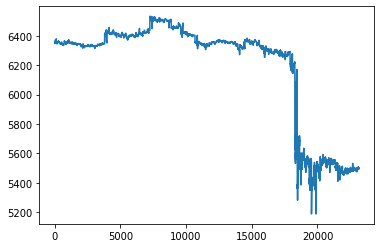

In [25]:
plt.plot(market_data[1])

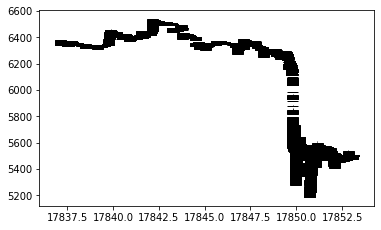

In [40]:
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
candlestick_ohlc(ax,quotes = zip(mdates.date2num(market_data[0].transform(lambda x: datetime.fromtimestamp(x))),
                         market_data[1], market_data[2],
                         market_data[3], market_data[4]),
                 width=0.6)
plt.show()